<a href="https://colab.research.google.com/github/bacchus00/deep-learning-submissions/blob/main/Tarea_1_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CC6204 - Deep Learning**
#### **Integrantes:** Sebastián Contreras, Fran Zautzik

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [ ]:
import pathlib
import random
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability
*   delayed healing
*   partial paresis
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\].

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2022-09-20 20:20:08--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34682 (34K) [application/x-httpd-php]
Saving to: ‘diabetes_data_upload.csv.1’

diabetes_data_uploa 100%[===================>]  33.87K  --.-KB/s    in 0.01s   

2022-09-20 20:20:08 (3.01 MB/s) - ‘diabetes_data_upload.csv.1’ saved [34682/34682]



In [ ]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [ ]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [ ]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')

In [ ]:
#Convertimos todo a arrays Numpy
#Se modifico este codigo para dejar todo en tensores de pytorch
#no tener problemas de tipos posteriormente
X_train = torch.tensor(train_dataset.to_numpy()).float()
X_test = torch.tensor(test_dataset.to_numpy()).float()

Y_train = torch.tensor(train_labels.to_numpy()).float()
Y_test = torch.tensor(test_labels.to_numpy()).float()

Y_train = Y_train[:, None]
Y_test = Y_test[:, None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

torch.Size([415, 16])
torch.Size([415, 1])
torch.Size([104, 16])
torch.Size([104, 1])


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20.
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [ ]:
SEED = 666

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
'''Se asumio el conjunto de testing como conjunto de validacion por que no
se pide que se utilize el conjunto de testing en ningun lado de la tarea y para poder ver la
capacidad de generalizacion de los modelos durante entrenamiento'''

train_data = torch.utils.data.TensorDataset(X_train, Y_train)
valid_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

In [ ]:
BATCH_SIZE = 20
lr = 0.01
train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
class MLP(nn.Module):
  # We need to define two methods at leats: constructor and forward

  #Constructor is for member definitions
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.fc1 = nn.Linear(input_dim, 250)
    self.fc2 = nn.Linear(250, 100)
    self.fc3 = nn.Linear(100, output_dim)
    self.fc4 = nn.Sigmoid()

  #Forward: what happens when we feed the network with data
  def forward(self, input):
    batch_size = input.shape[0]
    input = input.view(batch_size, -1)
    h_1 = F.relu(self.fc1(input))
    h_2 = F.relu(self.fc2(h_1))
    h_3 = self.fc3(h_2)
    y_pred = self.fc4(h_3)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred

In [ ]:
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=lr)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
  y_pred_class = (y_pred[0:] > 0.5).long()
  correct = y_pred_class.eq(y.view_as(y_pred_class)).sum()
  acc = correct.float()/y.shape[0]
  return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation
  model.train()

  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.to(device) #Labels

    optimizer.zero_grad() #Clean gradients

    y_pred = model(x) #Feed the network with data

    loss = criterion(y_pred, y) #Compute the loss

    acc = calculate_accuracy(y_pred, y) #Compute the accuracy

    loss.backward() #Compute gradients

    optimizer.step() #Apply update rules

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for
  #training (dropout for instance)
  model.eval()

  with torch.no_grad(): #disable the autograd engine (save computation and memory)

    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 1000

best_valid_loss = float('inf')

train_loss_by_epoch = np.zeros(EPOCHS)
train_acc_by_epoch = np.zeros(EPOCHS)
valid_loss_by_epoch = np.zeros(EPOCHS)
valid_acc_by_epoch = np.zeros(EPOCHS)

best_epoch = -1

for epoch in range(EPOCHS):

  start_time = time.time()

  #Train + validation cycles
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  #Guardamos la loss y accuracy en la epoca actual
  train_loss_by_epoch[epoch] = train_loss
  train_acc_by_epoch[epoch] = train_acc
  valid_loss_by_epoch[epoch] = valid_loss
  valid_acc_by_epoch[epoch] = valid_acc

  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    best_epoch = epoch
    torch.save(model.state_dict(), 'saved-model.pt')

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print('Best Epoch: ', best_epoch, ', Best Validation Loss: ', best_valid_loss, ', Last Validaton Loss: ', valid_loss_by_epoch[-1])

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.681 | Train Acc: 58.49%
	 Val. Loss: 0.668 |  Val. Acc: 63.33%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.657 | Train Acc: 61.11%
	 Val. Loss: 0.644 |  Val. Acc: 63.33%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.636 | Train Acc: 61.35%
	 Val. Loss: 0.622 |  Val. Acc: 63.33%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.617 | Train Acc: 61.35%
	 Val. Loss: 0.603 |  Val. Acc: 63.33%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.600 | Train Acc: 61.35%
	 Val. Loss: 0.585 |  Val. Acc: 63.33%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 61.35%
	 Val. Loss: 0.568 |  Val. Acc: 63.33%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.570 | Train Acc: 61.35%
	 Val. Loss: 0.553 |  Val. Acc: 63.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.556 | Train Acc: 61.35%
	 Val. Loss: 0.539 |  Val. Acc: 63.33%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.543 | Train Acc: 61.35%
	 Val. Loss: 0.526 |  Val. Acc: 63.33%
Epoch: 10 | Epoch Time: 0m 0

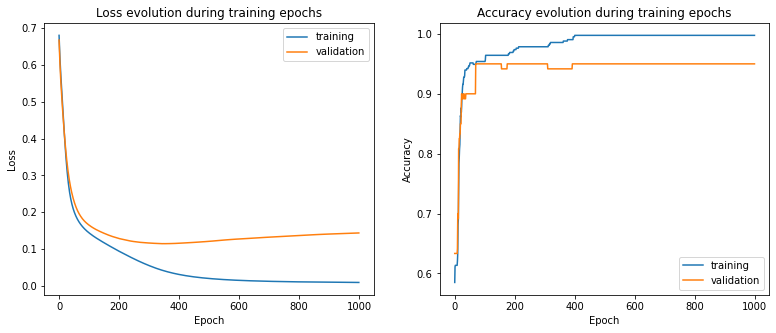

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(train_loss_by_epoch))

ax[0].plot(epochs, train_loss_by_epoch, label='training')
ax[0].plot(epochs, valid_loss_by_epoch, label='validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training epochs')
ax[0].legend()

ax[1].plot(epochs, train_acc_by_epoch, label='training')
ax[1].plot(epochs, valid_acc_by_epoch, label='validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training epochs')
ax[1].legend()

plt.show()

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

Best Epoch:  0 , Best Validation Loss:  0.23080674653241517 , Last Validaton Loss:  38.46153846153846


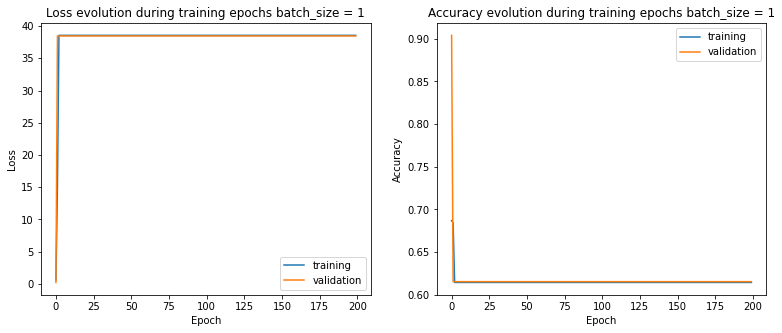

Best Epoch:  10 , Best Validation Loss:  0.07338532691673291 , Last Validaton Loss:  0.14317965706058286


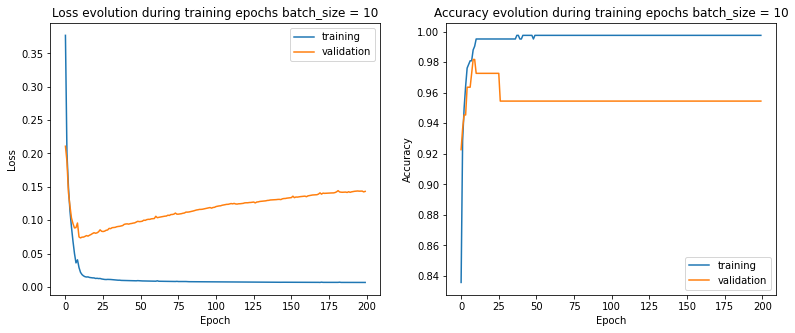

Best Epoch:  42 , Best Validation Loss:  0.05149792740121484 , Last Validaton Loss:  0.07794162986101583


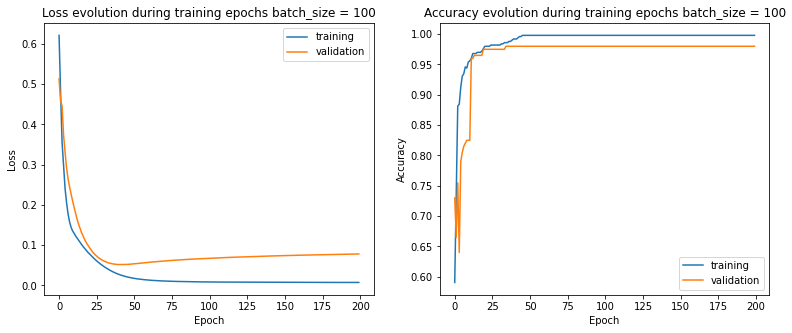

Best Epoch:  52 , Best Validation Loss:  0.10088708996772766 , Last Validaton Loss:  0.14221447706222534


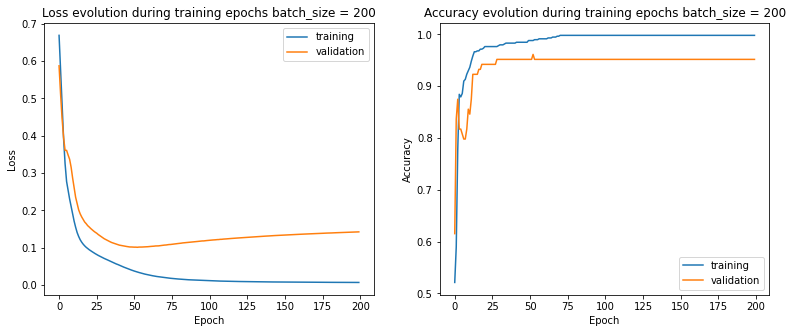

Best Epoch:  199 , Best Validation Loss:  0.08697961270809174 , Last Validaton Loss:  0.08697961270809174


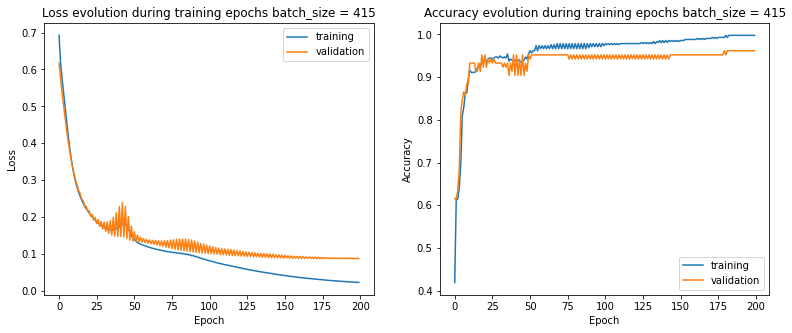

In [ ]:
batch_sizes = [1, 10, 100, 200, 415]

for batch_size in batch_sizes:

  train_iterator = data.DataLoader(train_data, batch_size=batch_size)
  valid_iterator = data.DataLoader(valid_data, batch_size=batch_size)

  model = MLP(INPUT_DIM, OUTPUT_DIM)
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.BCELoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  criterion = criterion.to(device)

  EPOCHS = 200

  best_valid_loss = float('inf')

  train_loss_by_epoch = np.zeros(EPOCHS)
  train_acc_by_epoch = np.zeros(EPOCHS)
  valid_loss_by_epoch = np.zeros(EPOCHS)
  valid_acc_by_epoch = np.zeros(EPOCHS)
  best_epoch = -1

  for epoch in range(EPOCHS):

    start_time = time.time()

    #Train + validation cycles
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    #Guardamos la loss y accuracy en la epoca actual
    train_loss_by_epoch[epoch] = train_loss
    train_acc_by_epoch[epoch] = train_acc
    valid_loss_by_epoch[epoch] = valid_loss
    valid_acc_by_epoch[epoch] = valid_acc

    #If we find a smaller loss, we save the model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      best_epoch = epoch
      torch.save(model.state_dict(), 'saved-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
  print('Best Epoch: ', best_epoch, ', Best Validation Loss: ', best_valid_loss, ', Last Validaton Loss: ', valid_loss_by_epoch[-1])

  fig, ax = plt.subplots(1, 2, figsize=(13, 5))
  fig.set_facecolor('white')

  epochs = np.arange(len(train_loss_by_epoch))

  ax[0].plot(epochs, train_loss_by_epoch, label='training')
  ax[0].plot(epochs, valid_loss_by_epoch, label='validation')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss evolution during training epochs batch_size = '+ str(batch_size))
  ax[0].legend()

  ax[1].plot(epochs, train_acc_by_epoch, label='training')
  ax[1].plot(epochs, valid_acc_by_epoch, label='validation')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Accuracy evolution during training epochs batch_size = '+ str(batch_size))
  ax[1].legend()

  plt.show()

**Respuesta:**

Observando el gráfico de loss para un mini batch de tamaño 1 se ve que el modelo no es capaz de reducir la loss a menos de 0.2 en las epocas iniciales para el conjunto de validación, y luego empieza a aumentar estabilizandose en un valor de 38.

Para el caso de mini batch de tamaño 10, en el conjunto de validacion, la loss llega a un valor mínimo de 0.07 en las epocas iniciales pero luego empeza a aumentar la loss a un valor de aproximadamente 0.14.

En el caso de mini batch de tamaño 100 podemos ver que es el modelo con el mejor desempeño obteniendo para el conjunto de validacion una loss mínima de 0.05 y aumentando solamente hasta 0.08.

Para mini batches de tamaño 200, se llega a una loss de validacion mínima de 0.1 y luego aumenta para estabilizarse cerca de 0.14

Y finalmente con mini batches de tamaño 451 (tamaño igual al dataset de entrenamiento) la loss en validación oscila mucho pero podemos apreciarse que disminuye hasta 0.09 y podríamos decir que si bien han pasado bastantes épocas, el modelo podría seguir mejorando.

Después de analizar todos los gráficos, se puede concluir que un mini batch de tamaño 100 es el óptimo en este problema. Adicionalmente para casi todos los casos se puede ver que primero se llega a un loss minimo en validacion y luego empieza a aumentar pues el modelo empresa a sobreajustarse a los ejemplos. También es importante destacar que a medida que aumenta el tamaño del minibatch el valor minimo del error de validación se da en una epoca mas tardía.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

Best Epoch:  499 , Best Validation Loss:  0.6839567621548971 , Last Validaton Loss:  0.6839567621548971


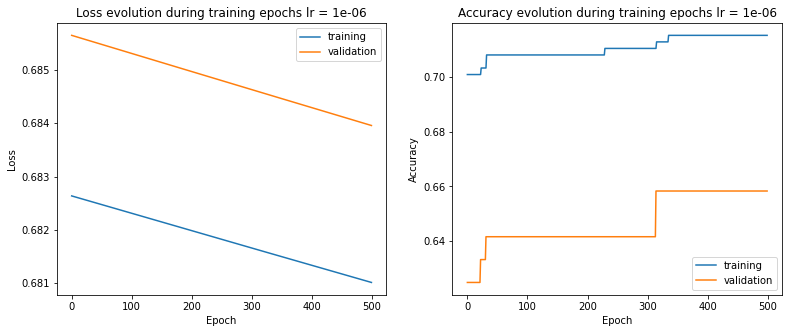

Best Epoch:  499 , Best Validation Loss:  0.592486580212911 , Last Validaton Loss:  0.592486580212911


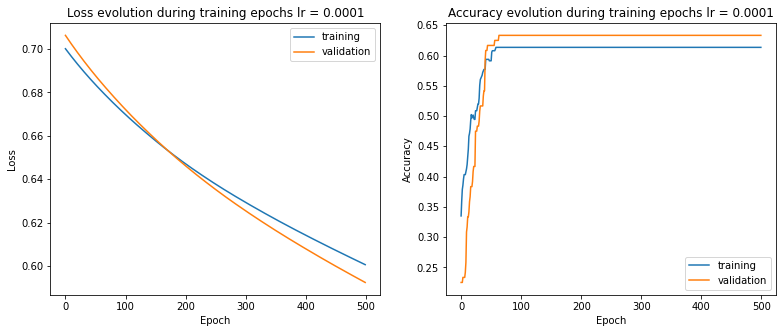

Best Epoch:  499 , Best Validation Loss:  0.22032888233661652 , Last Validaton Loss:  0.22032888233661652


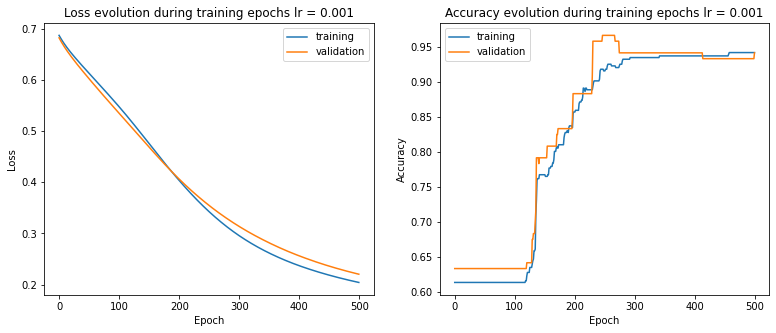

Best Epoch:  357 , Best Validation Loss:  0.08648974681273103 , Last Validaton Loss:  0.08789659027631085


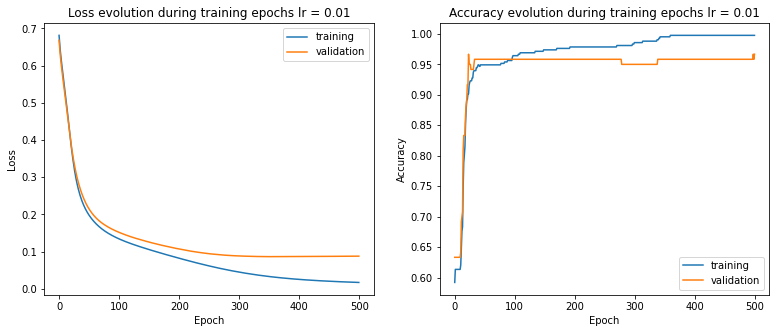

Best Epoch:  10 , Best Validation Loss:  0.0750839370302856 , Last Validaton Loss:  0.1702440611412991


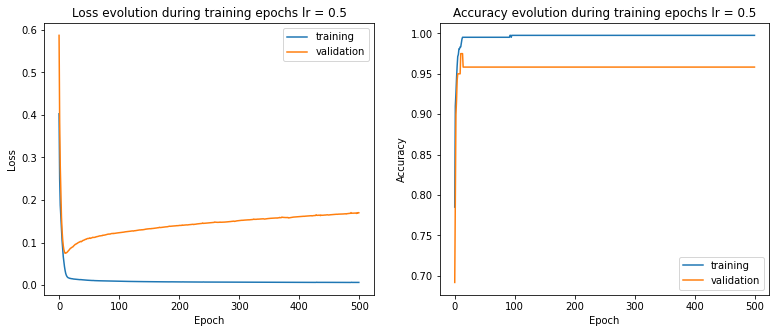

In [ ]:
lrs = [0.000001, 0.0001, 0.001, 0.01, 0.5]

best_epoch = -1

for lr in lrs:

  model = MLP(INPUT_DIM, OUTPUT_DIM)
  optimizer = optim.SGD(model.parameters(), lr=lr)
  criterion = nn.BCELoss()
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  criterion = criterion.to(device)

  EPOCHS = 500

  best_valid_loss = float('inf')

  train_loss_by_epoch = np.zeros(EPOCHS)
  train_acc_by_epoch = np.zeros(EPOCHS)
  valid_loss_by_epoch = np.zeros(EPOCHS)
  valid_acc_by_epoch = np.zeros(EPOCHS)

  for epoch in range(EPOCHS):

    start_time = time.time()

    #Train + validation cycles
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    #Guardamos la loss y accuracy en la epoca actual
    train_loss_by_epoch[epoch] = train_loss
    train_acc_by_epoch[epoch] = train_acc
    valid_loss_by_epoch[epoch] = valid_loss
    valid_acc_by_epoch[epoch] = valid_acc

    #If we find a smaller loss, we save the model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      best_epoch = epoch
      torch.save(model.state_dict(), 'saved-model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  print('Best Epoch: ', best_epoch, ', Best Validation Loss: ', best_valid_loss, ', Last Validaton Loss: ', valid_loss_by_epoch[-1])

  fig, ax = plt.subplots(1, 2, figsize=(13, 5))
  fig.set_facecolor('white')

  epochs = np.arange(len(train_loss_by_epoch))

  ax[0].plot(epochs, train_loss_by_epoch, label='training')
  ax[0].plot(epochs, valid_loss_by_epoch, label='validation')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss evolution during training epochs lr = '+ str(lr))
  ax[0].legend()

  ax[1].plot(epochs, train_acc_by_epoch, label='training')
  ax[1].plot(epochs, valid_acc_by_epoch, label='validation')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Accuracy evolution during training epochs lr = '+ str(lr))
  ax[1].legend()

  plt.show()

**Respuesta:**

Podemos observar en el caso de learning rate 0.0000001 que el loss de validacion disminuye linealmente y de forma muy lenta, no alcanza a llegar a estabilizarse y su valor mínimo es de 0.68.

Para el caso de learning rate 0.0001 podemos ver algo similar al caso anterior pero con una disminución más rápida. En este caso el valor mínimo que alcanza es de 0.59 para el loss de validacion.

Viendo los gráficos del caso de learning rate 0.001 podemos apreciar que es el primero que muestra algo más parecido al comportamiento esperado de una red que está aprendiendo de forma correcta. El valor mínimo que alcanza es de 0.22 para la loss de validación.

Al ver los resultados del caso de learning rate 0.01 podemos apreciar que es el primer caso en el que el valor de loss se estabiliza. El mínimo valor que alcanza es de 0.08 pero parece seguir aumentando.

Finalmente, para el caso de learning rate 0.5 podemos ver que es el único que al llegar a un mínimo de loss en validacion de 0.07 luego comienza a aumentar hasta 0.17.

Con esta comparación se hace aparente que en este problema learning rates muy pequeños, es decir más pequeños en orden de magnitud que 0.01, se demoran muchas épocas más en reducir el loss a un nivel estable y learning rates más grandes se llega a un loss minimo en validacion y luego comienza a aumentar lo que indica empeza a sobreajustarse a la data de entrenamiento.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

Best Epoch:  199 , Best Validation Loss:  0.11115839704871178 , Last Validaton Loss:  0.11115839704871178


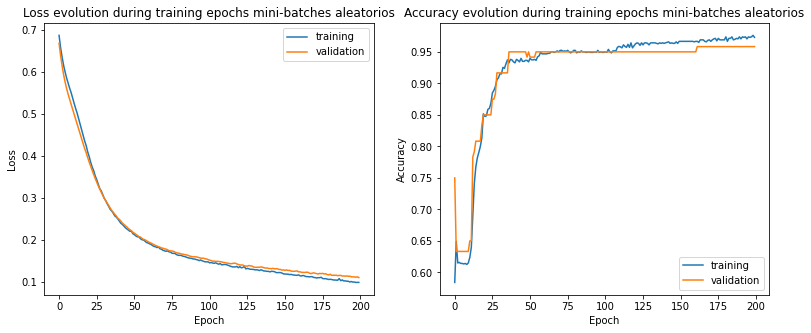

In [ ]:
train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

EPOCHS = 200

best_valid_loss = float('inf')

train_loss_by_epoch = np.zeros(EPOCHS)
train_acc_by_epoch = np.zeros(EPOCHS)
valid_loss_by_epoch = np.zeros(EPOCHS)
valid_acc_by_epoch = np.zeros(EPOCHS)

best_epoch = -1

for epoch in range(EPOCHS):

  start_time = time.time()

  #Train + validation cycles
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  #Guardamos la loss y accuracy en la epoca actual
  train_loss_by_epoch[epoch] = train_loss
  train_acc_by_epoch[epoch] = train_acc
  valid_loss_by_epoch[epoch] = valid_loss
  valid_acc_by_epoch[epoch] = valid_acc

  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    best_epoch = epoch
    torch.save(model.state_dict(), 'saved-model.pt')

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  #print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print('Best Epoch: ', best_epoch, ', Best Validation Loss: ', best_valid_loss, ', Last Validaton Loss: ', valid_loss_by_epoch[-1])

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
fig.set_facecolor('white')

epochs = np.arange(len(train_loss_by_epoch))

ax[0].plot(epochs, train_loss_by_epoch, label='training')
ax[0].plot(epochs, valid_loss_by_epoch, label='validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss evolution during training epochs mini-batches aleatorios')
ax[0].legend()

ax[1].plot(epochs, train_acc_by_epoch, label='training')
ax[1].plot(epochs, valid_acc_by_epoch, label='validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy evolution during training epochs mini-batches aleatorios')
ax[1].legend()

plt.show()

**Respuesta:**

Podemos ver que si bien tanto el caso de mini batches ordenados como el caso de mini batches generados de forma aleatoria convergen a un valor aproximado de 0.11 de loss, esta convergencia sucede de forma diferente para cada caso. En el caso de mini batches ordenados, el loss se presenta como una curva menos ruidosa y el accuracy como una curva con menos saltos y más estable que el caso generado al azar. Esto puede deberse a que generar los mini batch de forma aleatoria según época hace que la estimación de los gradientes de un mini batch sea diferente cada época. Esto se ve reflejado como una función de loss que, a diferencia del caso de mini batches ordenados, varía para cada mini batch según época.